# KNN REGRESSOR

In [1]:
# basics
import os, sys

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# data viewer
from sscode.config import data_path
from sscode.data import Loader, load_moana_hindcast_ss
from sscode.pca import PCA_DynamicPred
from sscode.cca import CCA_Analysis
from sscode.linear import MultiLinear_Regression
from sscode.knn import KNN_Regression
from sscode.plotting.utils import plot_ccrs_nz
from sscode.plotting.validation import plot_stats

# warnings
import warnings
warnings.filterwarnings('ignore')

## load the data


 loading the sea-level-pressure fields... 


 loading daily resampled data... 



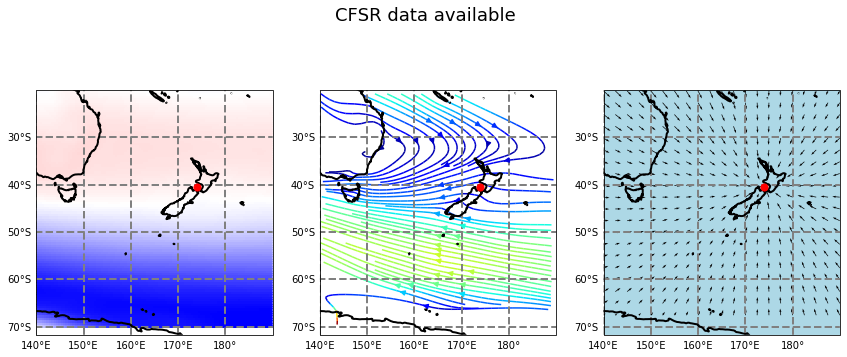


 loading the Moana v2 hindcast data... 



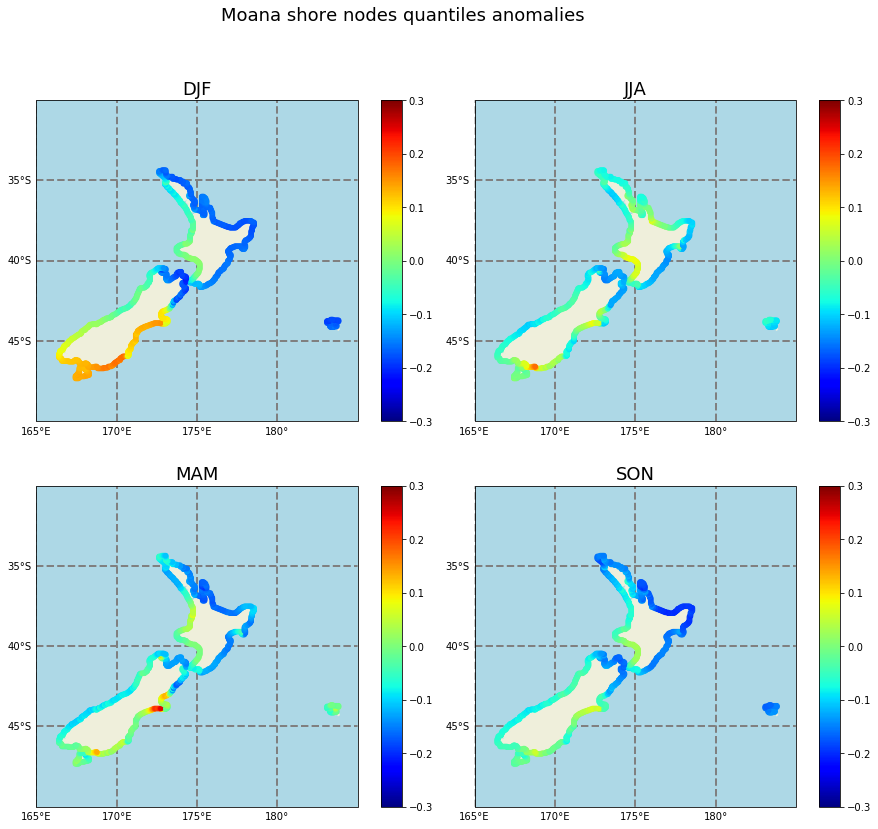


 loading and plotting the UHSLC tidal guages... 



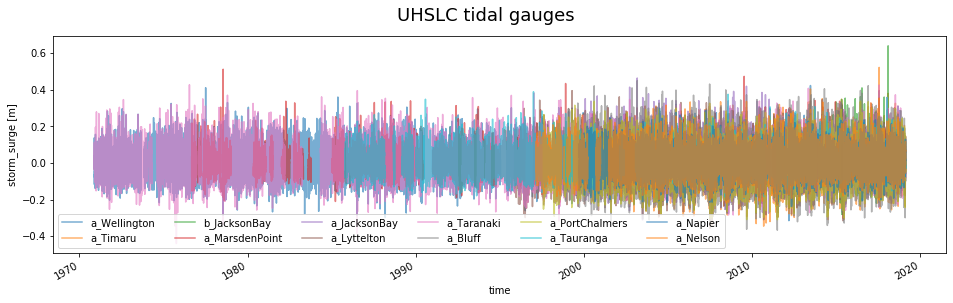

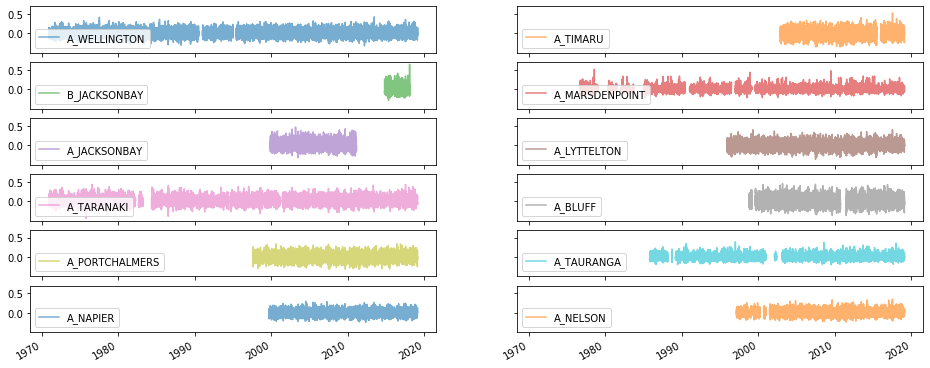

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc']
)

In [3]:
load_cfsr_moana_uhslc.location

(173.9, -40.5)

## load / calculate the pcs


 plotting 3 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



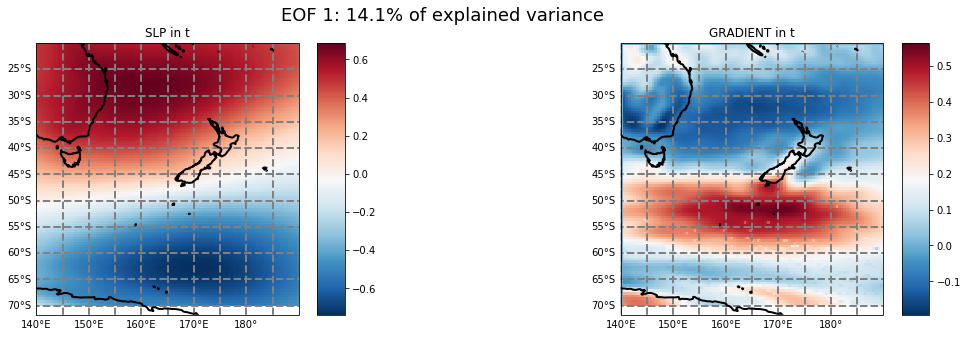

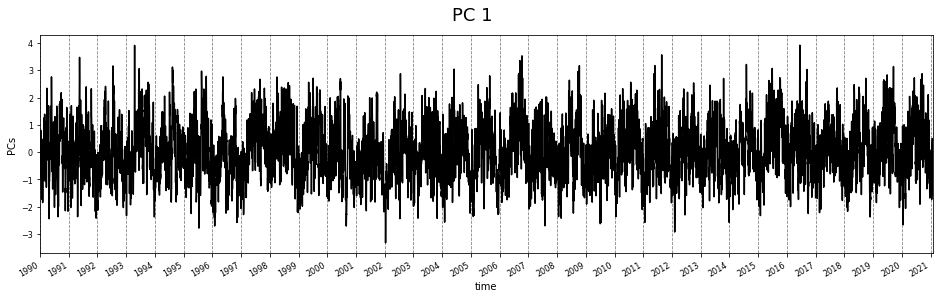

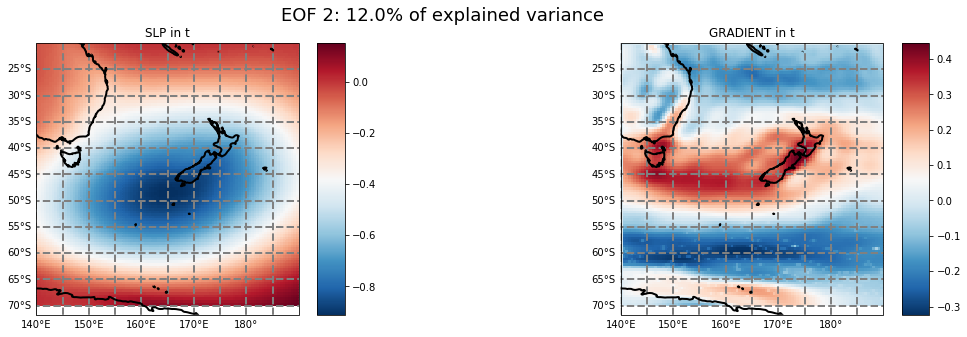

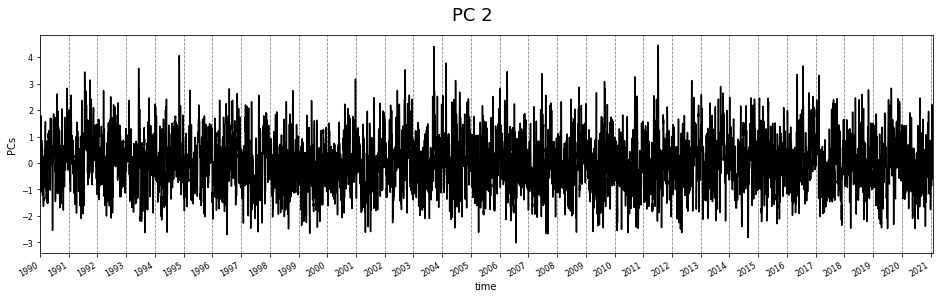

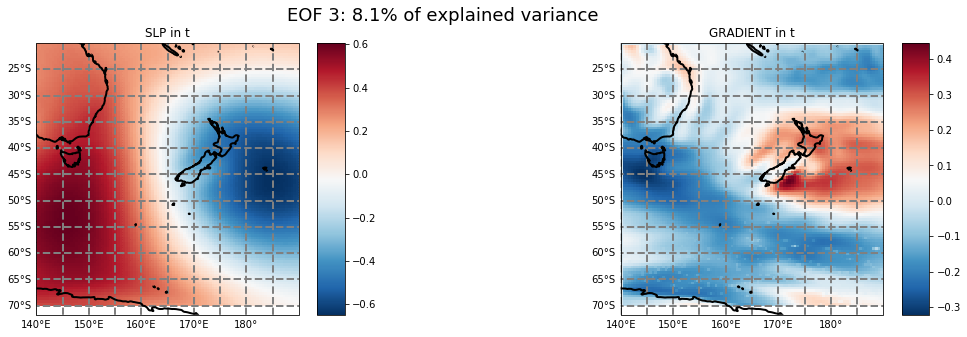

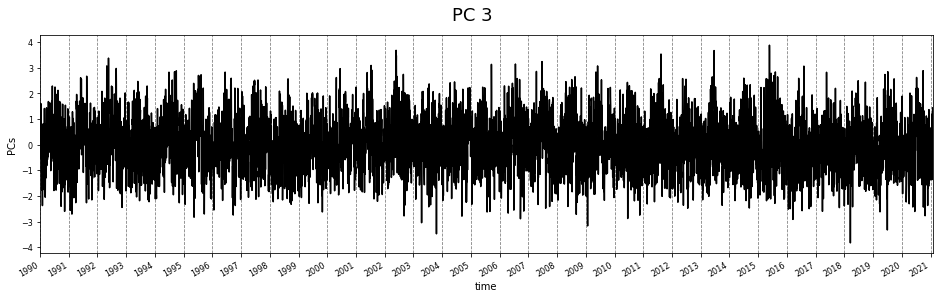

In [4]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    from sscode.plotting.pca import plot_pcs
    plot_pcs(pcs_cfsr,n_plot=3)
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp\
            .sel(time=slice('1990','2010')),
        # pres_vars=('wind_proj','lon','lat'),
        calculate_gradient=True,
        winds=(True,load_cfsr_moana_uhslc.predictor_wind),
        region=(True,(
            load_cfsr_moana_uhslc.location[0]-2.1,
            load_cfsr_moana_uhslc.location[0]+2.1,
            load_cfsr_moana_uhslc.location[1]+2.1,
            load_cfsr_moana_uhslc.location[1]-2.1
        )),
        time_lapse=2, # 1 equals to NO time delay 
        time_resample='1D',
        pca_plot=True
    )

## KNN regression with regional predictor

This is a snippet of the model outlook:

```python

    # perform the knn regression
    neigh = KNeighborsRegressor() # TODO: add params
    # specify parameters to test
    param_grid = {
        'n_neighbors': np.arange(1,k_neighbors,5),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    # use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(
        neigh, param_grid, cv=cv_folds,
        scoring='explained_variance',
        verbose=1
    ) 
    # TODO: add verbose and cv, DONE!!

    # fit model to data
    knn_gscv.fit(X, y) # input total data
    prediction = knn_gscv.predict(X)
    
    
```

where the best number of neighbors is selected, cross-validating the training and testing sizes!!


 KNN regression with 8 neighbors 



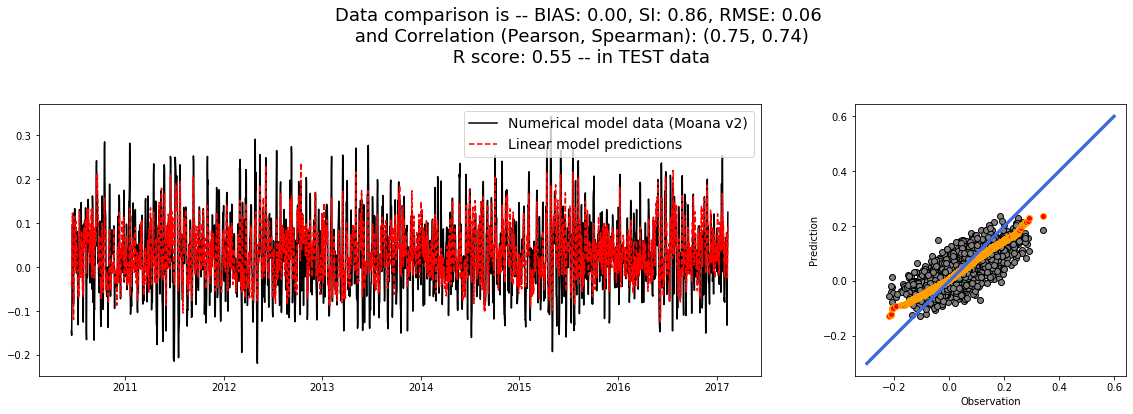

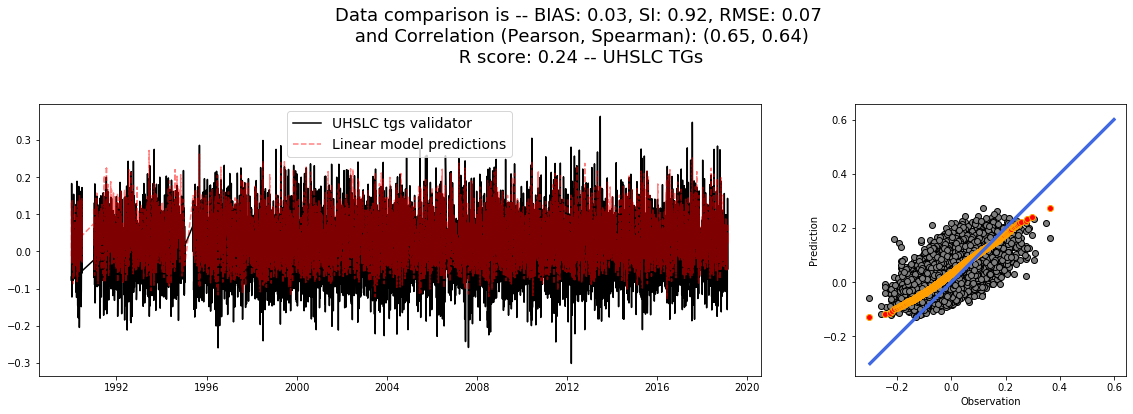


 KNN regression with 8 neighbors 



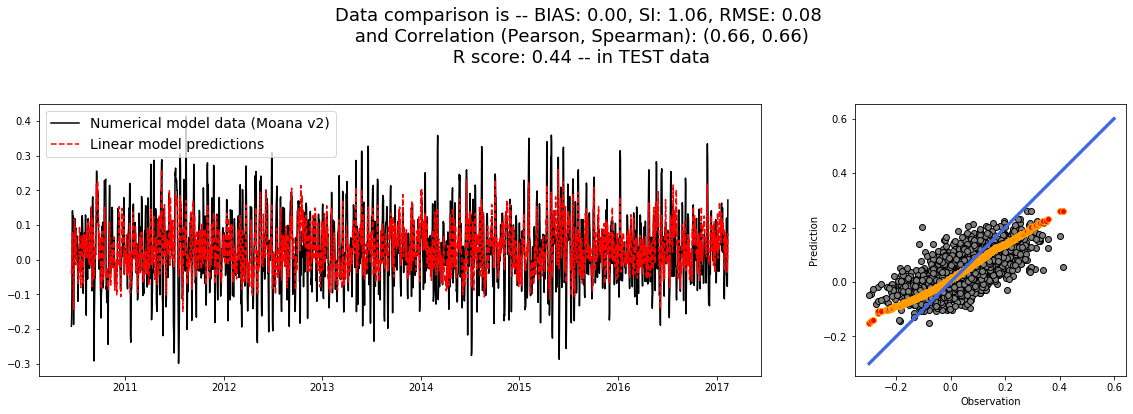

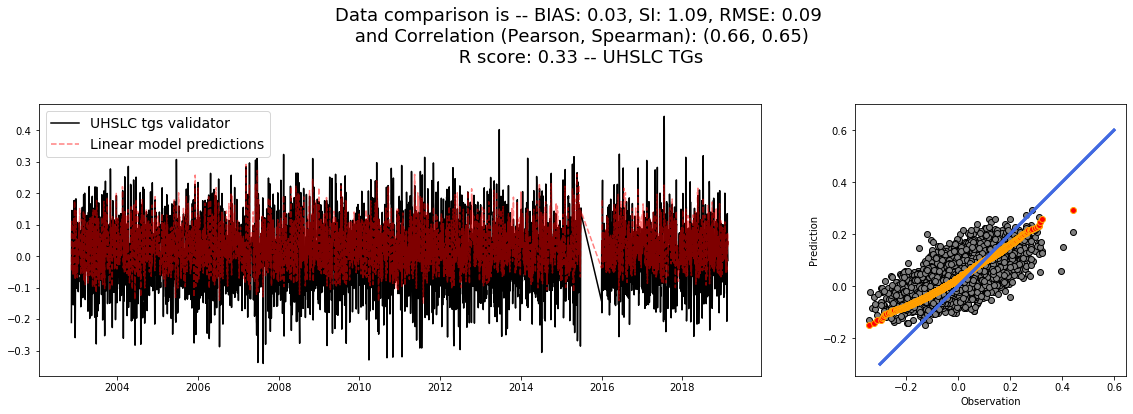


 KNN regression with 8 neighbors 



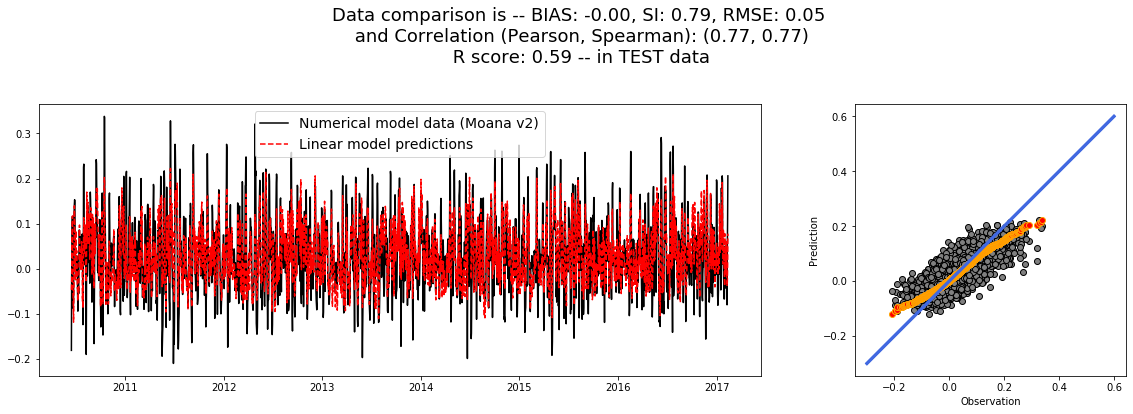

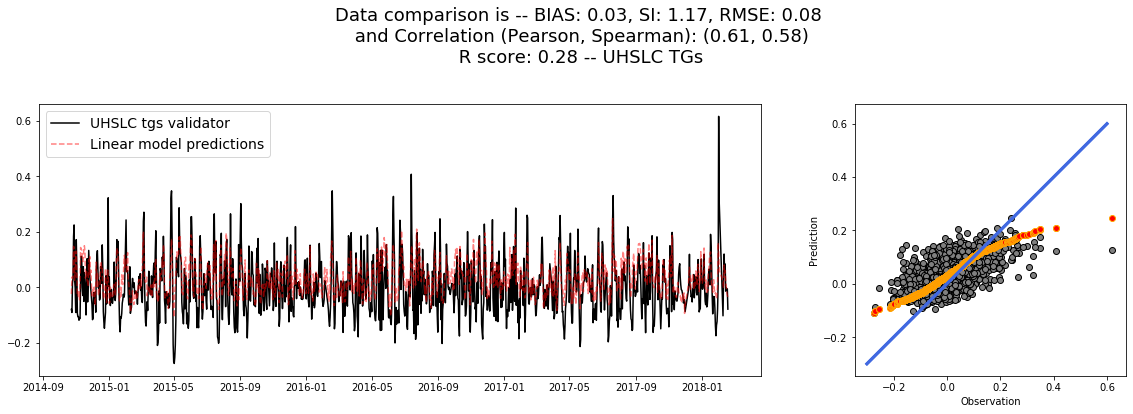


 KNN regression with 8 neighbors 



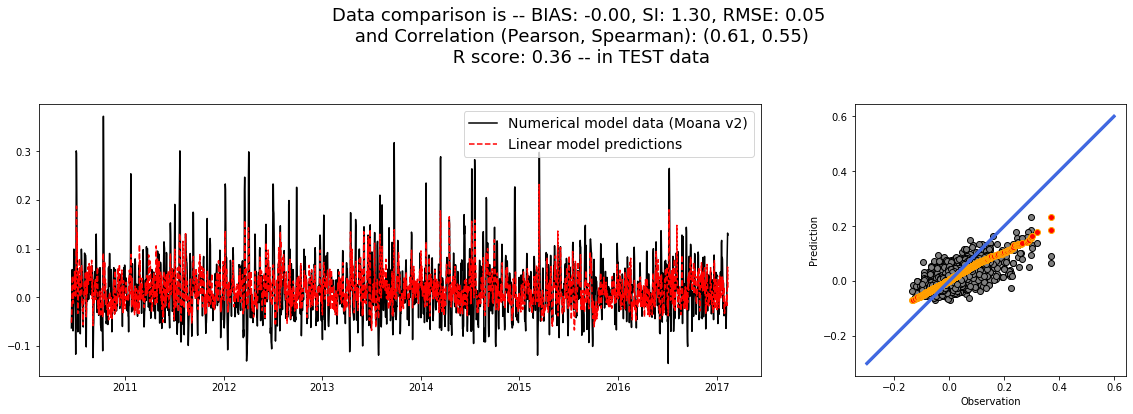

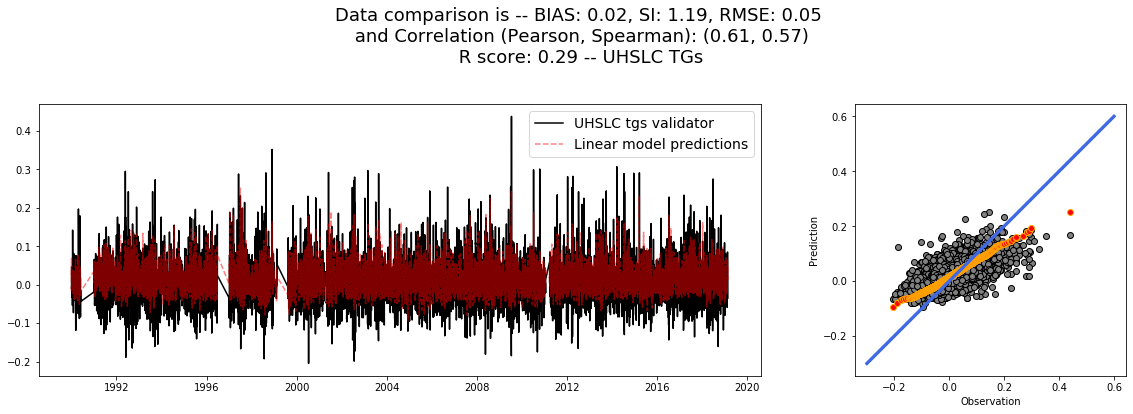


 KNN regression with 8 neighbors 



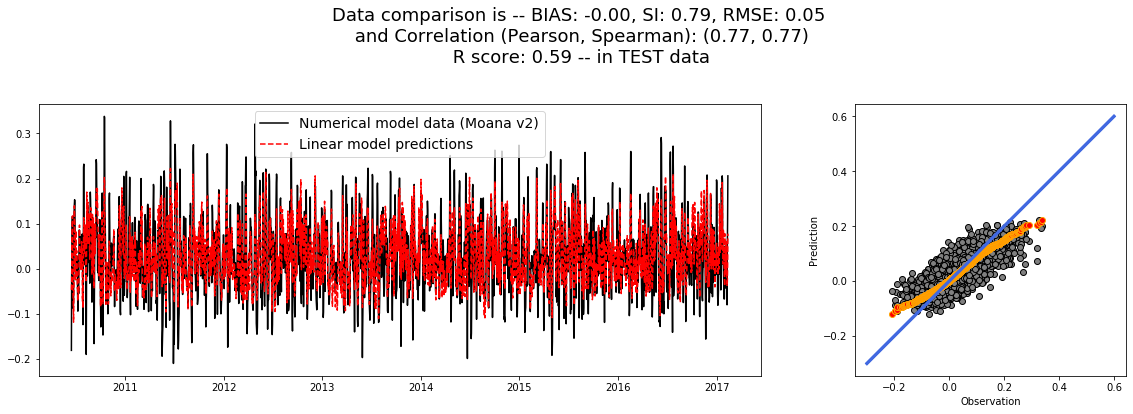

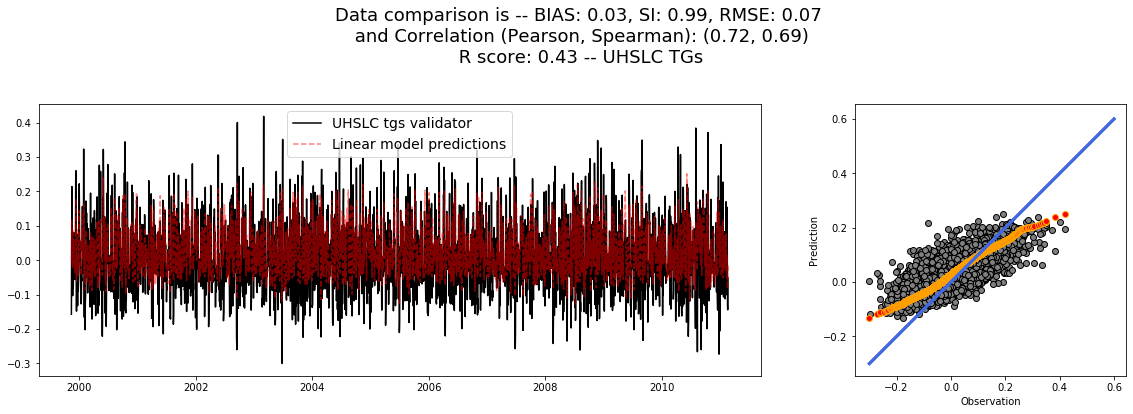


 KNN regression with 8 neighbors 



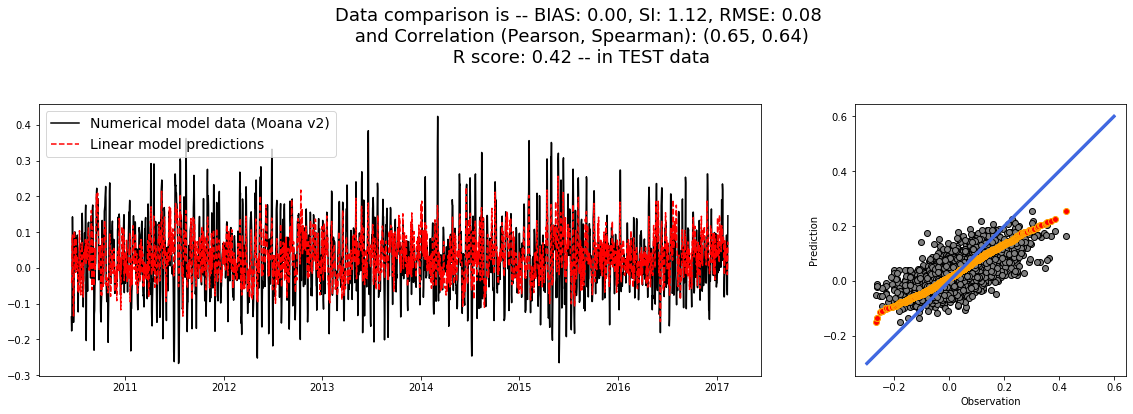

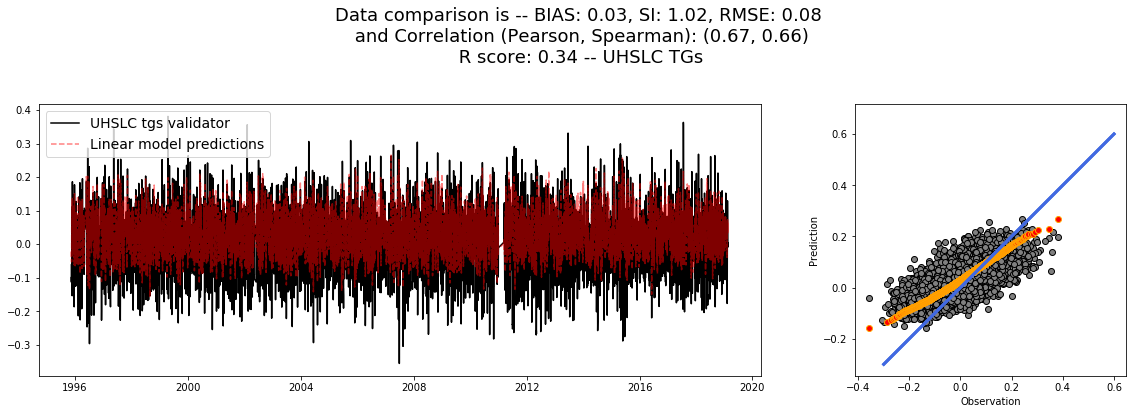


 KNN regression with 8 neighbors 



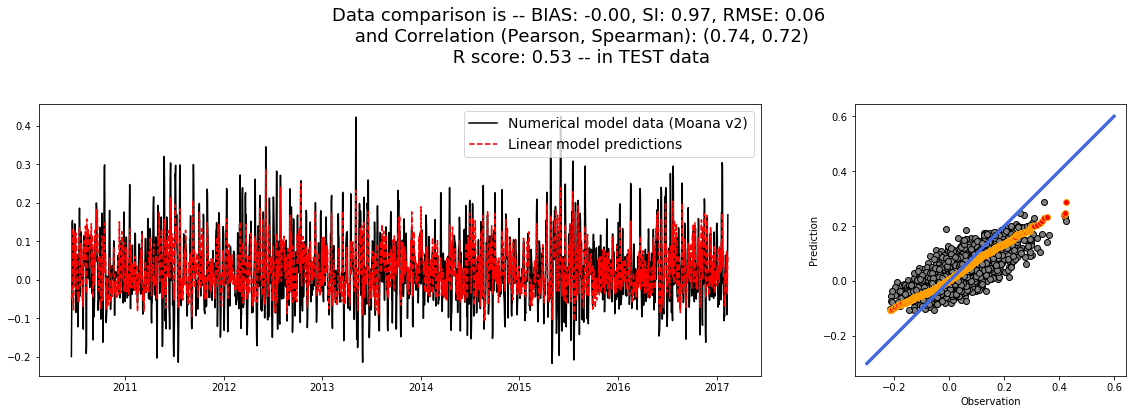

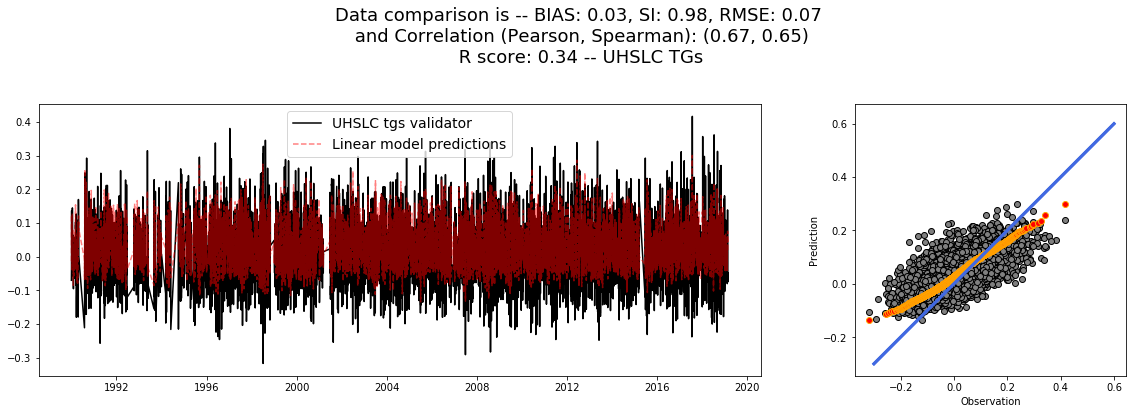


 KNN regression with 8 neighbors 



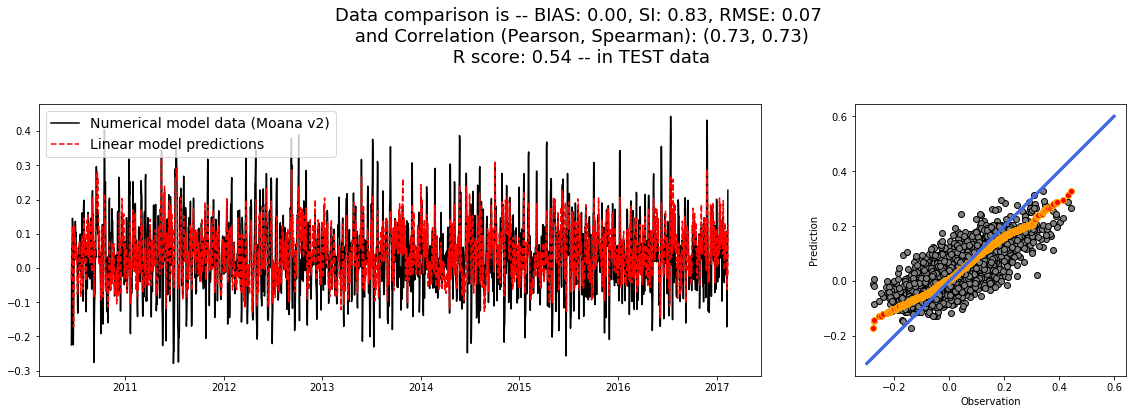

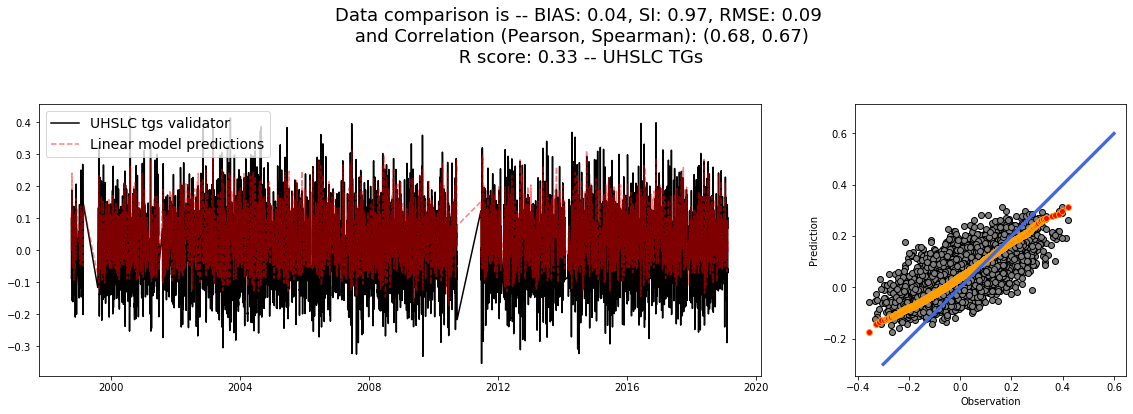


 KNN regression with 8 neighbors 



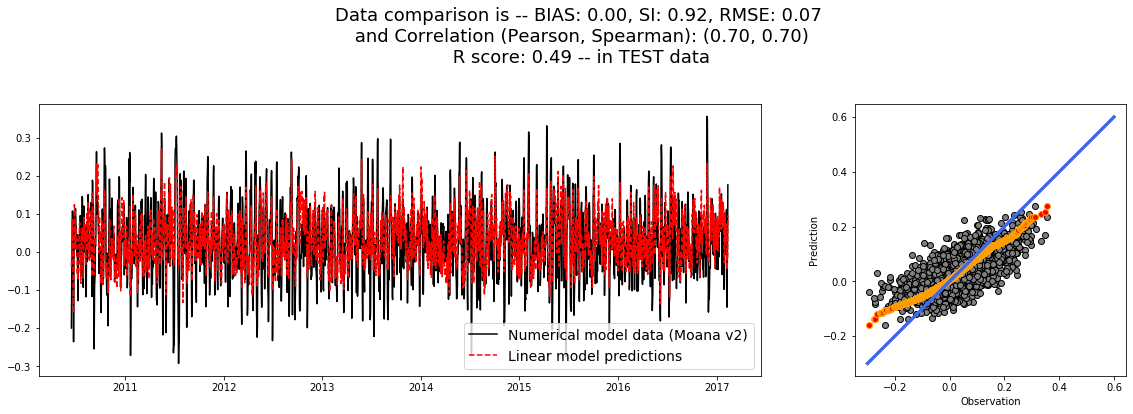

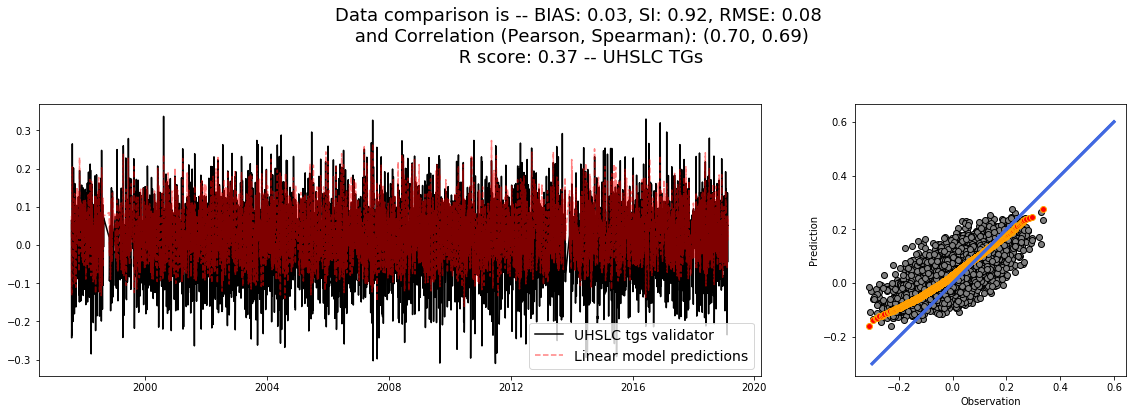


 KNN regression with 8 neighbors 



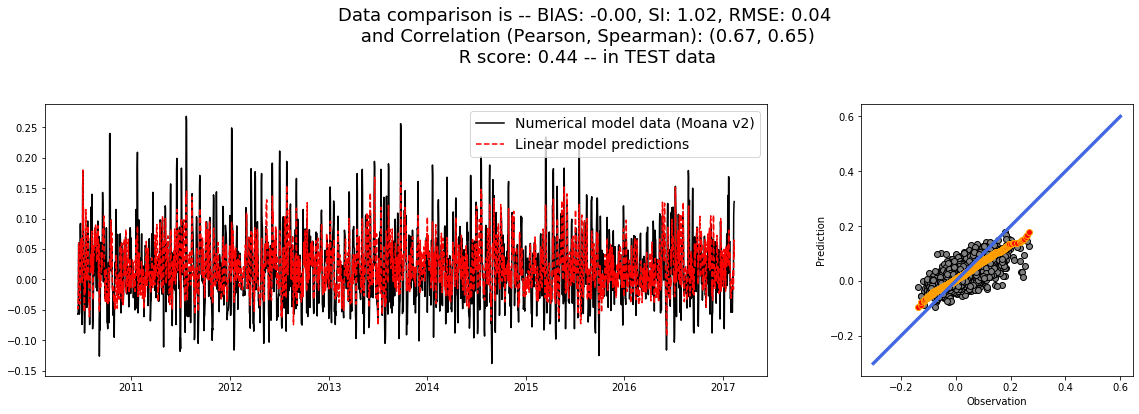

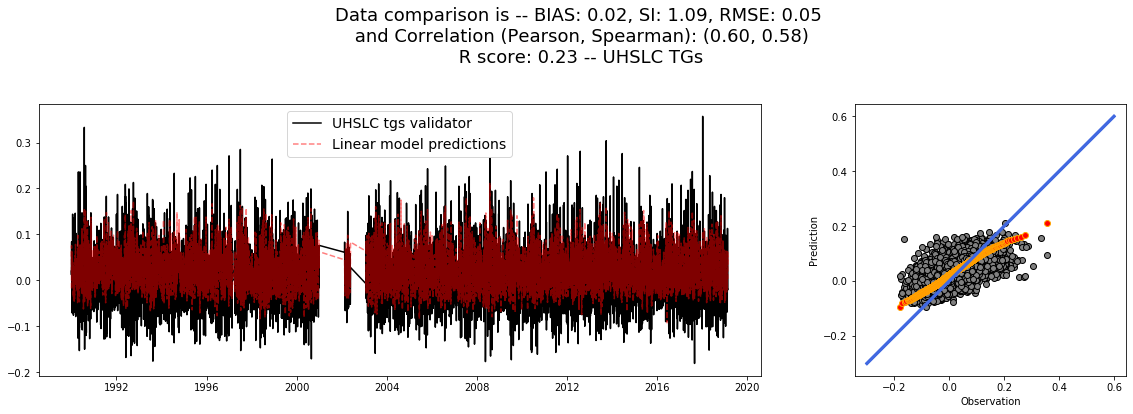


 KNN regression with 8 neighbors 



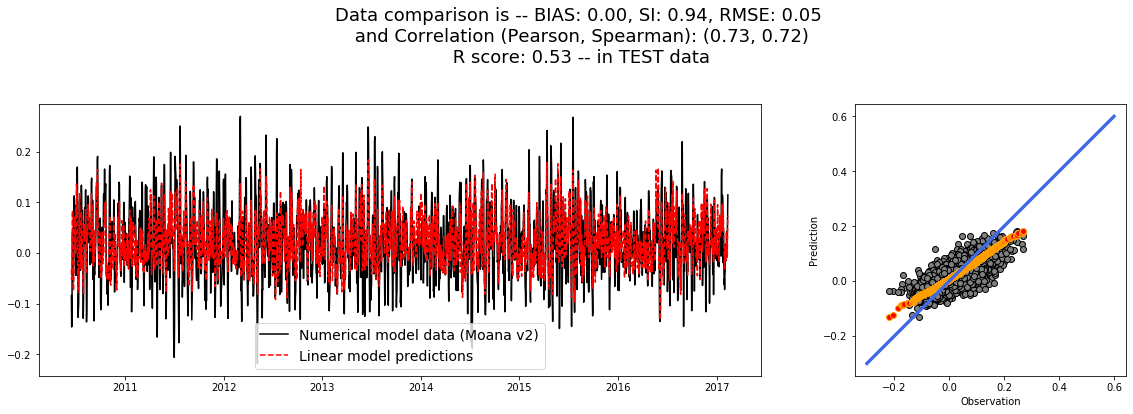

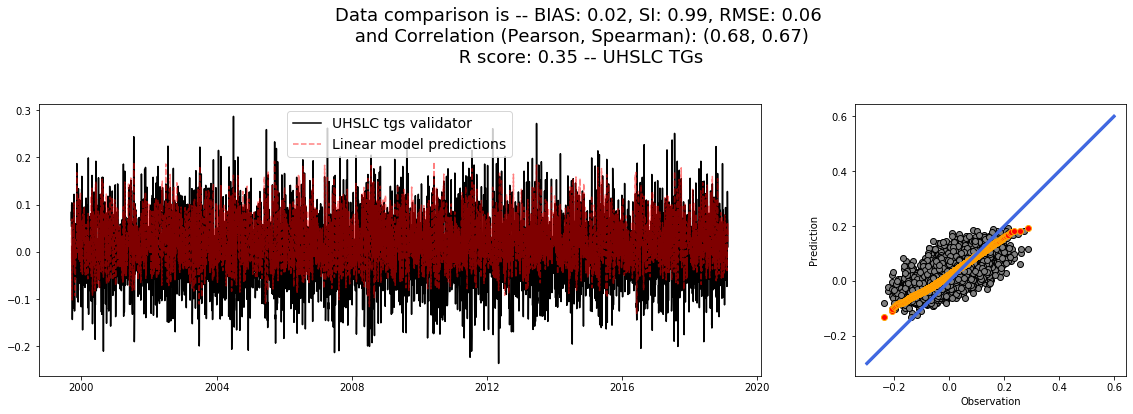


 KNN regression with 8 neighbors 



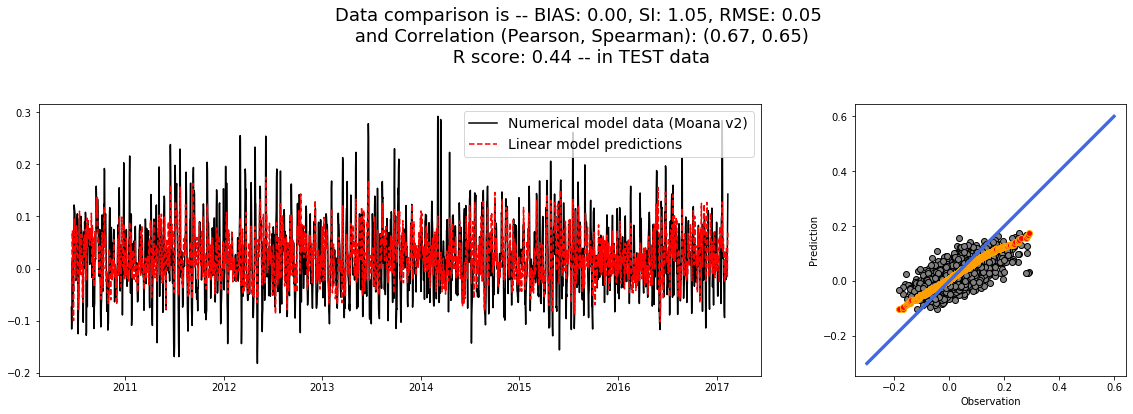

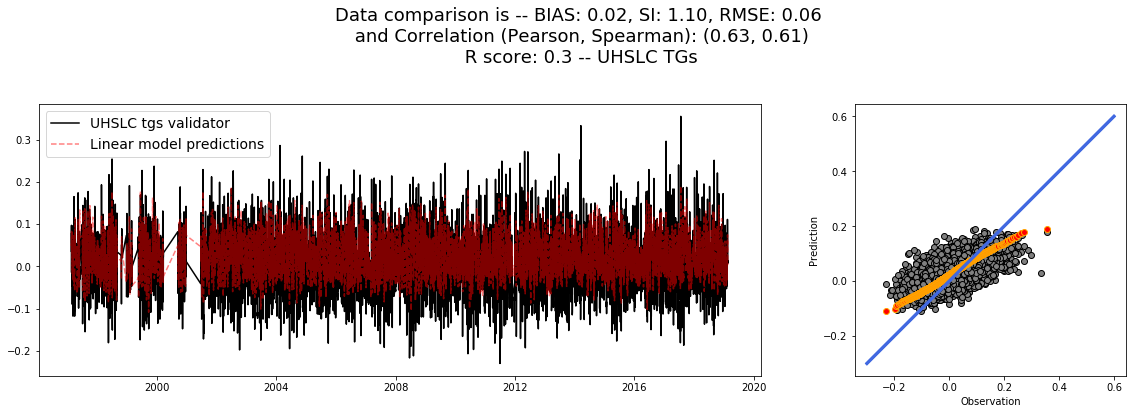

In [5]:
run = True
if run:
    # validate model with tgs
    stats_knn = []
    # select sites and append closest to UHSLC tgs
    clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
    for istat,stat in enumerate(clos_to_uhslc):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat = KNN_Regression(
            pcs_cfsr, ss_moana, validator=(
                True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
            ), plot_results=True, train_size=0.7
        )
        stats_knn.append(stats_stat)
    # save the statistics
    stats_knn = xr.Dataset(
        data_vars={
            'bias':(('station'),np.array(stats_knn)[:,0]),
            'si':(('station'),np.array(stats_knn)[:,1]),
            'rmse':(('station'),np.array(stats_knn)[:,2]),
            'pearson':(('station'),np.array(stats_knn)[:,3]),
            'spearman':(('station'),np.array(stats_knn)[:,4]),
            'rscore':(('station'),np.array(stats_knn)[:,5]),
            'latitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=clos_to_uhslc).lat),
            'longitude':(('station'),
                load_cfsr_moana_uhslc.predictand.sel(site=clos_to_uhslc).lon)
        },
        coords={
            'station': clos_to_uhslc
        }
    )
    # local copy
    if True:
        stats_knn.to_netcdf(data_path+'/statistics/stats_knn_regional_daily.nc')
else:
    stats_knn = xr.open_dataset(
        data_path+'/statistics/stats_knn_regional_daily.nc'
    )

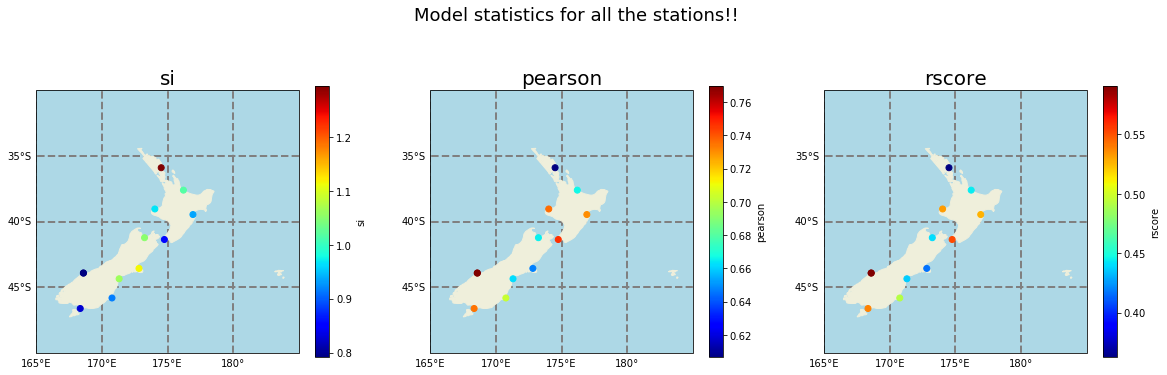

In [6]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_knn,plot_stats=['si','pearson','rscore'])